# Click Throughs
Will they click our ad?

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use classification models to make click-through predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [1]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from importlib import reload
import sklearn.preprocessing as pre


pd.options.display.float_format = '{:,.6f}'.format

#import my personal modules created for this report
import wrangle as w
import explore as e
import model as m

## Acquire

* Data acquired from interviewquery github on December 12, 2022.
* It contained 600000 rows and 24 columns
* Each observation represents an instance of an online advertisement
* Each column represents a feature of those visits

In [2]:
#import train and test data sets from interviewquery github
unclean_click_through_data = w.acquire_click_through_data()

## Prepare
* Checked for nulls, there were none
* Changed the ```hour``` column to datetime
* Split data into train, validate, and test (65/20/15)

In [3]:
#prep data
click_through_data = w.prep_data(unclean_click_through_data)

In [4]:
#split data
train, validate, test = w.split_data(click_through_data)

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
|**id**| | *int*|
| **hour** | The date and hour of day |*datetime*|
| **C1** | Anonymized categorical variable |*int*|
|**banner_pos**| Location of ad on the page | *int*|
|**site_id**| Id of the site where the ad was displayed | *str*|
|**site_domain**| | *str*|
|**site_category**| | *str*|
|**app_id**| Square footage of the land where the property is located | *float*|
|**app_domain**| | *float*|
|**deck**| | *float*|
|**pool**| | *float*|
|**garage**| | *float*|
|**hottub**| | *float*|
|**county**| Name of the county where the house is located| *string*|
|**2017_age**| Age of the house in 2017 (when the data was collected| *int*|
|**Target variable**
|**logerror**| 𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒) | *float* |

### A look at the data

In [5]:
#show the first few rows of the train data
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week,working_hours
366134,2009636145773373157,0,2014-10-27 16:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,16,Monday,True
95054,17172250707259950008,0,2014-10-24 06:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,2502,0,39,-1,221,6,Friday,False
189299,2922056073063093914,0,2014-10-25 13:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,...,320,50,1722,0,35,100083,79,13,Saturday,True
569650,4743847194723927815,0,2014-10-29 14:00:00,1010,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,...,320,50,2728,0,290,-1,42,14,Wednesday,True
581283,218700043766238420,1,2014-10-29 17:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,320,50,1993,2,1063,100084,33,17,Wednesday,True


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389999 entries, 366134 to 151297
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                389999 non-null  uint64        
 1   click             389999 non-null  int64         
 2   hour              389999 non-null  datetime64[ns]
 3   C1                389999 non-null  int64         
 4   banner_pos        389999 non-null  int64         
 5   site_id           389999 non-null  object        
 6   site_domain       389999 non-null  object        
 7   site_category     389999 non-null  object        
 8   app_id            389999 non-null  object        
 9   app_domain        389999 non-null  object        
 10  app_category      389999 non-null  object        
 11  device_id         389999 non-null  object        
 12  device_ip         389999 non-null  object        
 13  device_model      389999 non-null  object        
 14 

## Explore

### 1. What percentage of visits resulted in a click-through?

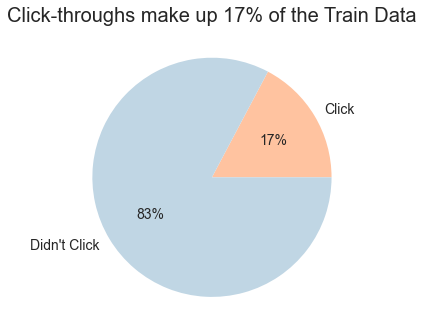

In [32]:
#show percentage of clicks
e.click_percentage(train)

### 2. Does the hour of the day have an impact of click-throughs?

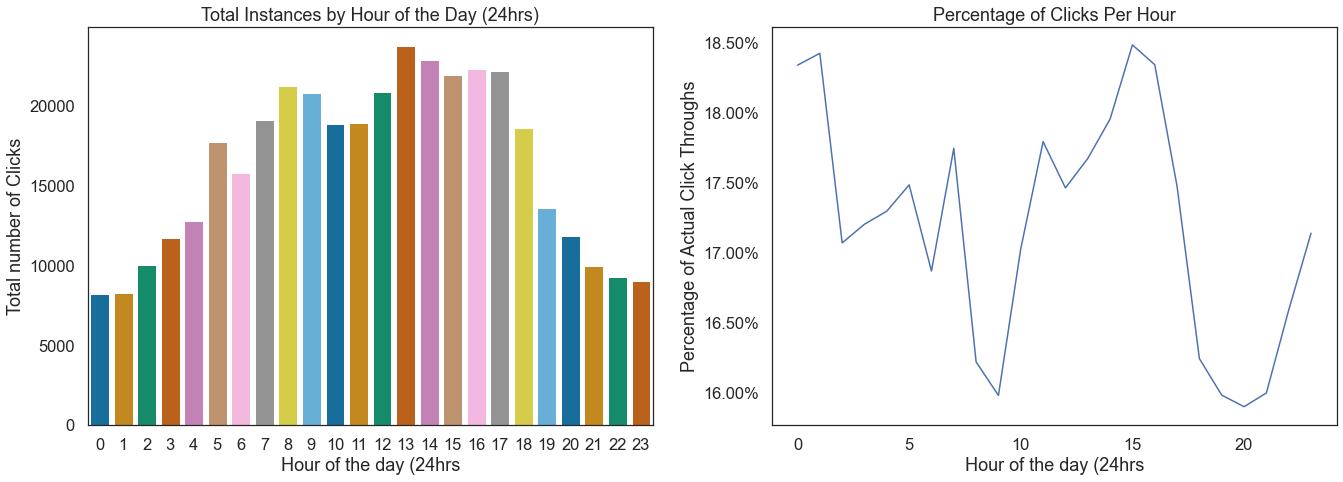

In [57]:
e.hour_click_through_viz(train)

**It looks like there are more click throughs per instance at 1 am.** 

***Let's do a $chi^2$ to see if there is a relationship***

**Set Hypothesis**

$H_0$ = There is no relationship between each ```hour_of_day``` and ```click```.

$H_a$ = There is a relationship between each ```hour_of_day``` and ```click```.

In [73]:
pd.set_option("display.max_columns", 50)

In [83]:
e.chi_square_matrix(train, 'hour_of_day', 'click').T

hour_of_day,15,9,16,8,19,20,18,21,14,1,0,11,7,13,22,6,17,5,12,10,2,23,4,3
χ^2,24.974033,24.494476,19.948293,16.443461,15.645811,15.374762,13.647408,10.994026,8.531434,8.129003,6.936594,4.153922,3.490100,3.218827,2.792559,1.592921,0.855082,0.733638,0.722513,0.628886,0.206261,0.064111,0.021792,0.011356
p-value,0.000001,0.000001,0.000008,0.000050,0.000076,0.000088,0.000221,0.000914,0.003491,0.004356,0.008445,0.041538,0.061737,0.072796,0.094703,0.206909,0.355119,0.391707,0.395321,0.427764,0.649714,0.800112,0.882641,0.915134


**p < alpha for ```hour_of_day``` (0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21) so we can reject the null hypothesis for those hours and say there is probably a relationship between those hours and ```clicks```**

## 3. Does the day of the week have an impact of click-throughs?

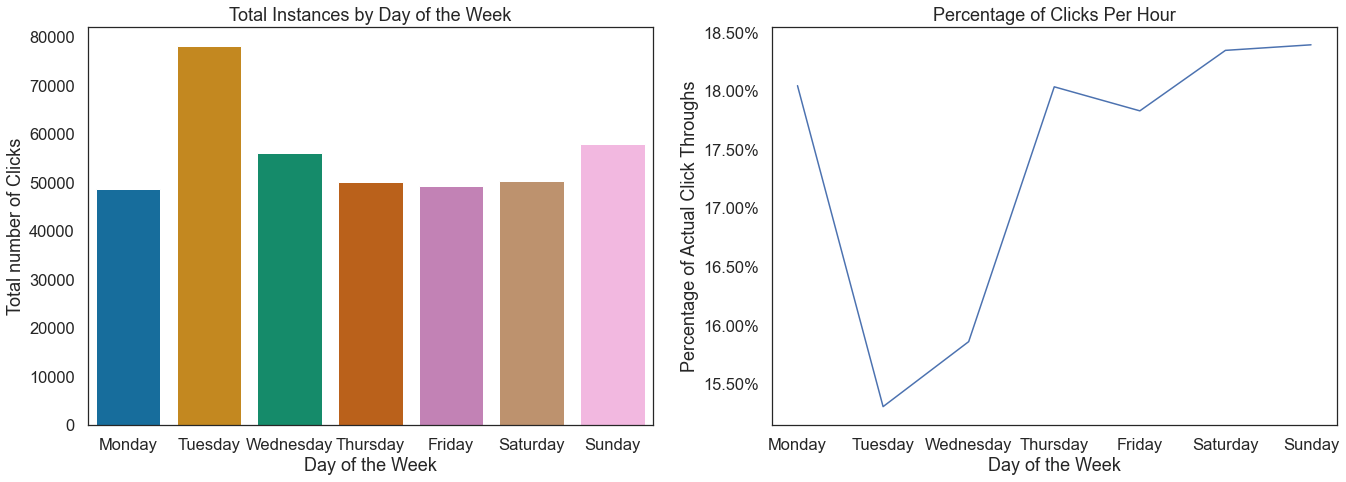

In [102]:
e.day_click_through_viz(train)

**Set Hypothesis**

$H_0$ = There is no relationship between each ```day_of_week``` and ```click```.

$H_a$ = There is a relationship between each ```day_of_week``` and ```click```.

In [103]:
e.chi_square_matrix(train, 'day_of_week', 'click')

,χ^2,p-value
day_of_week,,
Tuesday,256.610032,0.000000
Wednesday,87.576922,0.000000
Sunday,62.540524,0.000000
Saturday,48.801849,0.000000
Thursday,25.087336,0.000001
Monday,24.819706,0.000001
Friday,13.459815,0.000244


**p < alpha, so we can reject the null hypothesis and say there is probably a relationship between every ```day_of_week``` and ```click```.** 

## 4. Does banner position impact click through?

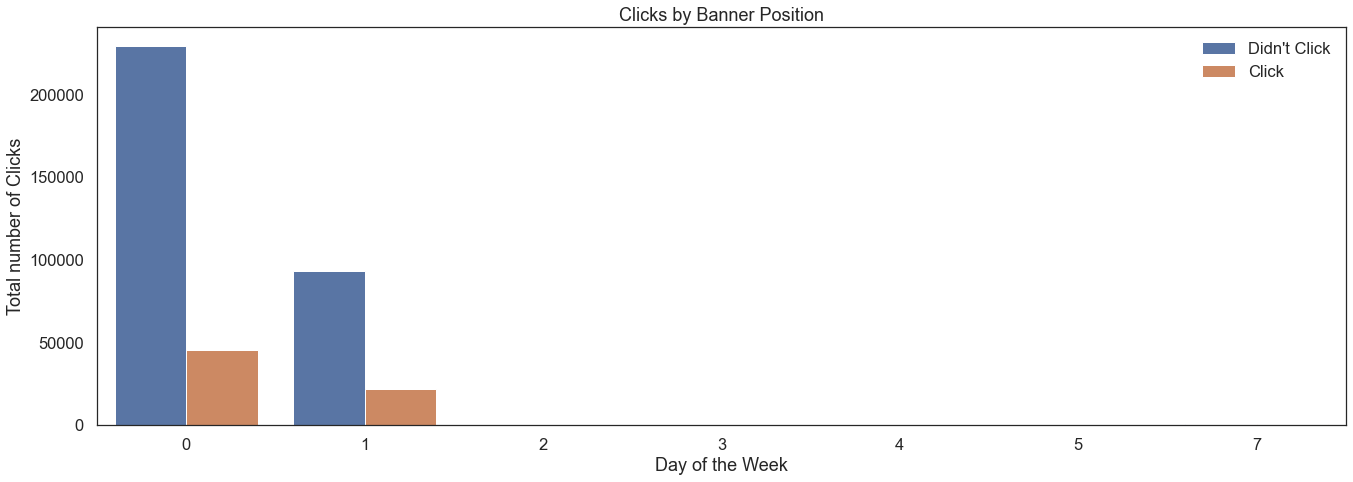

In [111]:
e.banner_pos_viz(train)

**Set Hypothesis**

$H_0$ = There is no association between each ```banner_pos``` and ```click```.

$H_a$ = There is a association between each ```banner_pos``` and ```click```.

In [113]:
e.chi_square_matrix(train, 'banner_pos', 'click').T

banner_pos,0,1,7,2,3,5,4
χ^2,419.231320,397.382334,72.117357,8.486756,0.342021,0.184251,0.036154
p-value,0.000000,0.000000,0.000000,0.003577,0.558665,0.667745,0.849197


**p < alpha, so we can reject the null hypothesis and say there is probably a relationship between ```banner_pos``` (0, 1, 2, 7) and ```click```.** 

## 5. Does

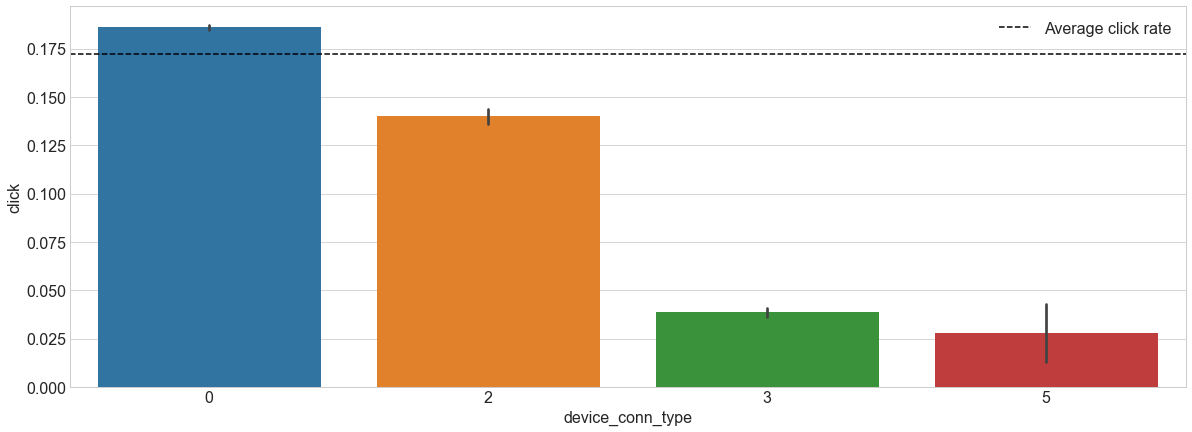

In [22]:
sns.barplot(x='device_conn_type', y='click', data=train)
rate = train['click'].mean()
plt.axhline(rate, label = f'Average click rate', linestyle='--', color='black')
plt.legend()
plt.show()

In [117]:
e.chi_square_matrix(train, 'device_conn_type', 'click').T

device_conn_type,3,0,2,5
χ^2,"3,552.025452","3,009.629469",231.552896,67.288990
p-value,0.000000,0.000000,0.000000,0.000000


### Exploration Summary
* ```hour_of_day``` (0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21) probably have a relationship with```clicks```.
* Each ```day_of_week``` probably has a relationship with ```click```.
* ```banner_pos``` (0, 1, 2, 7) probably have a relationship with ```click```.
* Each ```device_conn_type``` probably has a relationship with ```click```.

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|**hour_of_day_(0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21)**| |
|**day_of_week_(Monday-Sunday)**| |
|**banner_pos_(0, 1, 2, 7)**| |
|**device_conn_type**| |

### Features I'm not moving on with

| Feature | Reason 
|:--------|:-----------
|**parcelid**| id number that is not needed in the model
| **bathroooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
| **bedrooms** | Represented in the ```bath_bed_ratio``` so it would be redundant.
|**year_built**| Represented in the ```2017_age``` so it would be redundant.

### Prep for modeling
* Scale the numeric variables using the minmax scaler
* Encode categorical variables

In [24]:
cols_to_encode = ['banner_pos', 'hour_of_day', 'day_of_week', 'device_conn_type']

In [26]:
train, validate, test = m.pre_prep(train, validate, test, cols_to_encode, 'click')

In [126]:
hour_list = []
for num in (0, 1, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21):
    hour_list.append(f'hour_of_day_{num}')

In [127]:
hour_list

['hour_of_day_0',
 'hour_of_day_1',
 'hour_of_day_8',
 'hour_of_day_9',
 'hour_of_day_11',
 'hour_of_day_14',
 'hour_of_day_15',
 'hour_of_day_16',
 'hour_of_day_18',
 'hour_of_day_19',
 'hour_of_day_20',
 'hour_of_day_21']

In [139]:
pos = []
for num in (0, 1, 2, 7) :
    pos.append(f'banner_pos_{num}')

In [140]:
pos

['banner_pos_0', 'banner_pos_1', 'banner_pos_2', 'banner_pos_7']

In [141]:
drivers = ['hour_of_day_0',
 'hour_of_day_1',
 'hour_of_day_8',
 'hour_of_day_9',
 'hour_of_day_11',
 'hour_of_day_14',
 'hour_of_day_15',
 'hour_of_day_16',
 'hour_of_day_18',
 'hour_of_day_19',
 'hour_of_day_20',
 'hour_of_day_21', 
           'device_conn_type_0',
           'device_conn_type_2',
           'device_conn_type_3',
           'device_conn_type_5',
           'banner_pos_0', 'banner_pos_1', 'banner_pos_2', 'banner_pos_7']

In [142]:
X_train, y_train, X_validate, y_validate, X_test, y_test = m.prep_for_model(train, validate, test, 'click', drivers)

In [143]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389999 entries, 366134 to 151297
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   hour_of_day_0       389999 non-null  uint8
 1   hour_of_day_1       389999 non-null  uint8
 2   hour_of_day_8       389999 non-null  uint8
 3   hour_of_day_9       389999 non-null  uint8
 4   hour_of_day_11      389999 non-null  uint8
 5   hour_of_day_14      389999 non-null  uint8
 6   hour_of_day_15      389999 non-null  uint8
 7   hour_of_day_16      389999 non-null  uint8
 8   hour_of_day_18      389999 non-null  uint8
 9   hour_of_day_19      389999 non-null  uint8
 10  hour_of_day_20      389999 non-null  uint8
 11  hour_of_day_21      389999 non-null  uint8
 12  device_conn_type_0  389999 non-null  uint8
 13  device_conn_type_2  389999 non-null  uint8
 14  device_conn_type_3  389999 non-null  uint8
 15  device_conn_type_5  389999 non-null  uint8
 16  banner_pos_0   

### Baseline models
* Looked at both using mean and median as a baseline model.
* Mean baseline performed better on the in-sample and out-of sample data SO I went with mean.

In [144]:
#baseline based on the percentage of the mode
baseline = y_train.value_counts(normalize=True).max()
#print results
print(f'Baseline accuracy: {baseline:.2%}')

Baseline accuracy: 82.76%


### Model Comparison

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

In [146]:
########### DECICSION TREE HYPERPARAMETER TESTING####################

# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metric = []

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)
    y_pred_train = tree.predict(X_train)
    y_pred_validate = tree.predict(X_validate)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    in_sample_recall = recall_score(y_train, y_pred_train)
    out_of_sample_accuracy = tree.score(X_validate, y_validate)
    out_of_sample_recall = recall_score(y_train, y_pred_train)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        "train_recall": in_sample_recall,
        "validate_recall": out_of_sample_recall
    }
    
    metric.append(output)
    
df = pd.DataFrame(metric)
df["accuracy_diff"] = df.train_accuracy - df.validate_accuracy
df["recall_diff"] = df.train_recall - df.validate_recall

In [147]:
df.sort_values(by=['recall_diff' ,'accuracy_diff'])

,max_depth,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_diff,recall_diff
0,1,0.827571,0.827568,0.000000,0.000000,0.000003,0.000000
1,2,0.827571,0.827568,0.000000,0.000000,0.000003,0.000000
2,3,0.827571,0.827568,0.000000,0.000000,0.000003,0.000000
3,4,0.827587,0.827551,0.000238,0.000238,0.000035,0.000000
6,7,0.827600,0.827510,0.000506,0.000506,0.000090,0.000000
8,9,0.827602,0.827510,0.000535,0.000535,0.000092,0.000000
4,5,0.827594,0.827501,0.000416,0.000416,0.000093,0.000000
11,12,0.827605,0.827510,0.000565,0.000565,0.000095,0.000000
12,13,0.827605,0.827510,0.000565,0.000565,0.000095,0.000000
13,14,0.827607,0.827510,0.000580,0.000580,0.000097,0.000000


In [ ]:
m.random_forest_results(X_train, y_train, X_validate, y_validate)

In [ ]:
m.log_results(X_train, y_train, X_validate, y_validate)

### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* It was interesting that OLS Regressor and Lasso Lars both performed better on the out-of-sample data.

### Best model: Random Forest Model 
* I chose the XXX (XXXXXXXXXX) because the difference in $RMSE$ between the train and validate was around  and they were both higher than the other models
* I will now run the that model on test data to gauge how it will perform on future data

In [ ]:
#m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

## Conclusion

### Summary
*


### Recommendations
* We should do more research .
* .

### Next Steps
* In the next iteration:
    * 